In [1]:
%matplotlib inline

import numpy as np
import os
import json
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
nproc = range(1, 17)

In [3]:
def speedup(t_serial, t):
    return t_serial/t

In [4]:
def read_profiling_files(profile_dir_path=".", drop_multinode=False, drop_singlenode=False):
    profiling_data = pd.DataFrame()

    json_filenames = [file for file in os.listdir(profile_dir_path) if file.endswith("_profiling.json")]

    if(drop_singlenode):
        json_filenames = [file for file in json_filenames if "1_nodes" not in file]

    if(drop_multinode):
        json_filenames = [file for file in json_filenames if "1_nodes" in file]

    for json_filename in json_filenames:
        with open(os.path.join(profile_dir_path, json_filename)) as json_file:
            profiling_data = profiling_data.append(json.load(json_file), ignore_index=True)
            profiling_data = profiling_data.sort_values(by=["n_processes"], ignore_index=True)

    profiling_data.n_processes = profiling_data.n_processes.astype(int)
    profiling_data = profiling_data.sort_values(by=["n_processes"], ignore_index=True)

    return profiling_data

## Weak scaling

In [5]:
# DGX-2
#weak_scaling_profiling_data = read_profiling_files("output_dgx-2/weak_scaling/2022-06-09T134809/")
#weak_scaling_profiling_data = read_profiling_files("output_dgx-2/weak_scaling/2022-06-23T154025/")

# HGX
#weak_scaling_profiling_data = read_profiling_files("output_hgx/weak_scaling/2022-06-16T162931/")
##weak_scaling_profiling_data = read_profiling_files("output_hgx/weak_scaling/2022-06-16T170630/")

# Saga
#singlenode_weak_scaling_profiling_data = read_profiling_files("output_saga/weak_scaling/2022-06-16T151516/", drop_multinode=True)
#multinode_weak_scaling_profiling_data = read_profiling_files("output_saga/weak_scaling/2022-06-16T151516/", drop_singlenode=True)
singlenode_weak_scaling_profiling_data = read_profiling_files("output_saga/weak_scaling/2022-06-21T235600/", drop_multinode=True)
multinode_weak_scaling_profiling_data = read_profiling_files("output_saga/weak_scaling/2022-06-21T235600/", drop_singlenode=True)

print(singlenode_weak_scaling_profiling_data)
print(multinode_weak_scaling_profiling_data)

      t_init     t_total                                            outfile  \
0  13.151470  187.123114  /cluster/work/jobs/5995581/ShallowWaterGPU/mpi...   
1  17.898452  210.700137  /cluster/work/jobs/6040817/ShallowWaterGPU/mpi...   
2  19.701864  208.722497  /cluster/work/jobs/5995583/ShallowWaterGPU/mpi...   
3  22.790222  218.337566  /cluster/work/jobs/5995584/ShallowWaterGPU/mpi...   

   t_sim_init  t_nc_write  t_full_step  t_mpi_halo_exchange  \
0   12.316193   92.680975    67.334274                  0.0   
1   24.190988   97.482013    67.381501                  0.0   
2   21.237509   98.550311    67.510278                  0.0   
3   24.143164  102.122138    67.474521                  0.0   

   t_mpi_halo_exchange_download  t_mpi_halo_exchange_upload  \
0                     66.403320                    0.039551   
1                     66.379639                    0.048828   
2                     66.364868                    0.041748   
3                     66.378784     

## Strong scaling

In [6]:
def amdahls_speedup(parallel_share, nproc):
    serial_share = 1.0 - parallel_share
    return [1.0 / (serial_share + parallel_share / float(n)) for n in nproc]

In [7]:
def gustafsons_speedup(parallel_share, nproc):
    serial_share = 1.0 - parallel_share
    return [serial_share + parallel_share * float(n) for n in nproc]

In [8]:
# DGX-2
#strong_scaling_profiling_data = read_profiling_files("output_dgx-2/strong_scaling/2022-06-09T160712/")
#strong_scaling_profiling_data = read_profiling_files("output_dgx-2/strong_scaling/2022-06-23T172838/")

# HGX
#strong_scaling_profiling_data = read_profiling_files("output_hgx/strong_scaling/2022-06-16T152945/")

# Saga
singlenode_strong_scaling_profiling_data = read_profiling_files("output_saga/strong_scaling/2022-06-16T190721/", drop_multinode=True)
multinode_strong_scaling_profiling_data = read_profiling_files("output_saga/strong_scaling/2022-06-16T190721/", drop_singlenode=True)

print(singlenode_strong_scaling_profiling_data)
print(multinode_strong_scaling_profiling_data)

     t_init   t_total                                            outfile  \
0  9.692163  80.12349  /cluster/work/jobs/5977971/ShallowWaterGPU/mpi...   

   t_sim_init  t_nc_write  t_full_step  t_mpi_halo_exchange  \
0    8.455713   35.275914    24.448944                  0.0   

   t_mpi_halo_exchange_download  t_mpi_halo_exchange_upload  \
0                     23.929565                     0.03894   

   t_mpi_halo_exchange_sendreceive  t_mpi_step       nx      ny        dt  \
0                         0.340088    0.028564  24576.0  6144.0  0.000001   

   n_time_steps  slurm_job_id n_cuda_devices  n_processes  \
0         200.0     5977971.0              4            4   

                                     git_hash  \
0  0f0cbad2dd661c59f9a2c43740eda12d90cca413\n   

                                          git_status  
0   M saga_scaling_benchmark.job\n M saga_strong_...  
      t_init    t_total                                            outfile  \
0  10.973809  93.593265  /cl

## Plotting

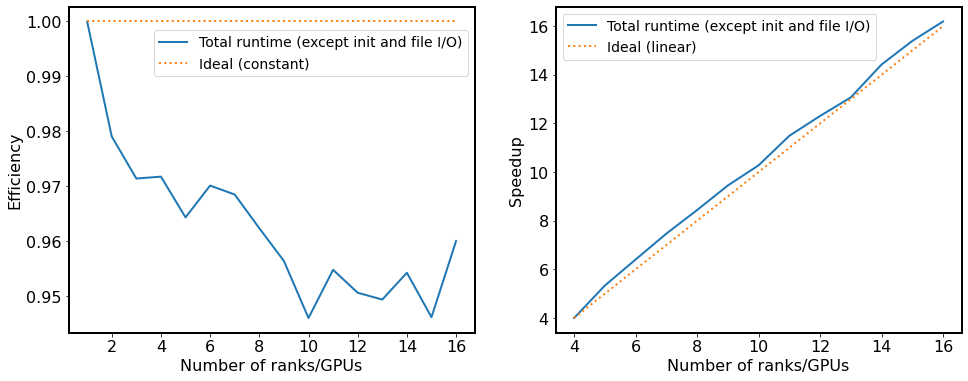

In [43]:
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2

fig, (ax_weak, ax_strong) = plt.subplots(1, 2, figsize=(16,6))

t_total_no_init_or_file_io = weak_scaling_profiling_data["t_total"] \
                            -weak_scaling_profiling_data["t_init"] \
                            -weak_scaling_profiling_data["t_nc_write"] \
                            -weak_scaling_profiling_data["t_sim_init"]

t_total_halo_exchange = weak_scaling_profiling_data["t_mpi_halo_exchange_download"] \
                        +weak_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"] \
                        +weak_scaling_profiling_data["t_mpi_halo_exchange_upload"]

#ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
#    speedup(t_total_no_init_or_file_io[0], t_total_no_init_or_file_io), label="Total (no init or file I/O)")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_full_step"][0], weak_scaling_profiling_data["t_full_step"]), label="Runtime (except init and file I/O)")
ax_weak.locator_params(axis="x", nbins=16)

"""
ax_weak.plot(weak_scaling_profiling_data["n_processes"][0:].to_numpy(dtype="int"), 
    speedup(t_total_halo_exchange[0], t_total_halo_exchange[0:]), label="Halo exchange (D/E/U)", linestyle="dashed")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_total"][0], weak_scaling_profiling_data["t_total"]), label="Total")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"][0], weak_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"]), label="MPI send/recv")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_mpi_halo_exchange_download"][0], weak_scaling_profiling_data["t_mpi_halo_exchange_download"]), label="Download (GPU->CPU)")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_mpi_halo_exchange_upload"][0], weak_scaling_profiling_data["t_mpi_halo_exchange_upload"]), label="Upload (CPU->GPU)")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_nc_write"][0], weak_scaling_profiling_data["t_nc_write"]), label="Write to file")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_init"][0], weak_scaling_profiling_data["t_init"]), label="Init")
"""

ax_weak.plot(nproc, np.ones(len(nproc)), label="Ideal runtime (constant)", linestyle="dotted")

ax_weak.set_xlabel("Number of ranks/GPUs")
ax_weak.set_ylabel("Efficiency")
ax_weak.legend(loc="upper right", bbox_to_anchor=[1.0, 0.95])
#fig.show()

##############################################

#fig, ax = plt.subplots(figsize=(8,6))

t_total_no_init_or_file_io = strong_scaling_profiling_data["t_total"] \
                            -strong_scaling_profiling_data["t_init"] \
                            -strong_scaling_profiling_data["t_nc_write"] \
                            -strong_scaling_profiling_data["t_sim_init"]

t_total_halo_exchange = strong_scaling_profiling_data["t_mpi_halo_exchange_download"] \
                        +strong_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"] \
                        +strong_scaling_profiling_data["t_mpi_halo_exchange_upload"]

#ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
#    speedup(t_total_no_init_or_file_io[0], t_total_no_init_or_file_io)*4, label="Total (no init or file I/O)")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_full_step"][0], strong_scaling_profiling_data["t_full_step"])*4, label="Runtime (except init and file I/O)")

"""
ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(t_total_halo_exchange[0], t_total_halo_exchange)*4, label="Halo exchange (D/E/U)", linestyle="dashed")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_total"][0], strong_scaling_profiling_data["t_total"])*4, label="Total")
    
ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"][0], strong_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"]), label="MPI send/recv")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_mpi_halo_exchange_download"][0], strong_scaling_profiling_data["t_mpi_halo_exchange_download"]), label="Download (GPU->CPU)")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_mpi_halo_exchange_upload"][0], strong_scaling_profiling_data["t_mpi_halo_exchange_upload"]), label="Upload (CPU->GPU)")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_nc_write"][0], strong_scaling_profiling_data["t_nc_write"]), label="Write to file")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_init"][0], strong_scaling_profiling_data["t_init"]), label="Init")
"""

#ax_strong.plot(nproc, amdahls_speedup(0.9, nproc), label="Amdahls 90%", linestyle="dashed")
#ax_strong.plot(nproc, amdahls_speedup(0.5, nproc), label="Amdahls 50%", linestyle="dashed")
#ax_strong.plot(nproc, amdahls_speedup(0.1, nproc), label="Amdahls 10%", linestyle="dashed")

#ax_strong.plot(nproc, gustafsons_speedup(0.9, nproc), label="Gustafsons 90%")
#ax_strong.plot(nproc, gustafsons_speedup(0.5, nproc), label="Gustafsons 50%")
#ax_strong.plot(nproc, gustafsons_speedup(0.1, nproc), label="Gustafsons 10%")

ax_strong.plot(nproc[3:], nproc[3:], label="Ideal runtime (linear)", linestyle="dotted")

ax_strong.set_xlabel("Number of ranks/GPUs")
ax_strong.set_ylabel("Speedup")
ax_strong.legend(loc="upper left")
fig.show()

fig.savefig("dgx-2-scaling.pdf", bbox_inches='tight')

/cluster/projects/nn9882k/martinls/.conda/envs/ShallowWaterGPU_HPC/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


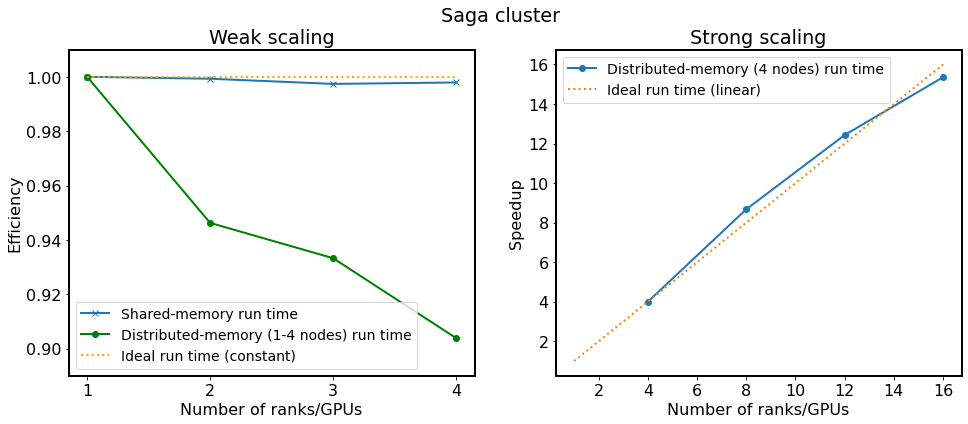

In [9]:
###
### Saga
###

plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2

fig, (ax_weak, ax_strong) = plt.subplots(1, 2, figsize=(16,6))

ax_weak.plot(singlenode_weak_scaling_profiling_data["n_processes"][0:4].to_numpy(dtype="int"), 
    speedup(singlenode_weak_scaling_profiling_data["t_full_step"][0], singlenode_weak_scaling_profiling_data["t_full_step"][0:4]), 
    label="Shared-memory run time", marker="x")

ax_weak.plot(singlenode_weak_scaling_profiling_data["n_processes"][0:4].to_numpy(dtype="int"), 
    speedup(singlenode_weak_scaling_profiling_data["t_full_step"][0], 
    np.append(singlenode_weak_scaling_profiling_data["t_full_step"][0], multinode_weak_scaling_profiling_data["t_full_step"][0:3])), 
    label="Distributed-memory (1-4 nodes) run time", marker="o", color="green")

ax_weak.locator_params(axis="x", nbins=4)
ax_weak.set_ylim(0.89, 1.01)

ax_weak.plot(nproc[0:4], np.ones(len(nproc[0:4])), label="Ideal run time (constant)", linestyle="dotted", color="orange")

ax_weak.set_xlabel("Number of ranks/GPUs")
ax_weak.set_ylabel("Efficiency")
ax_weak.legend(loc="lower left")
ax_weak.title.set_text("Weak scaling")

##############################################

#ax_strong.plot(singlenode_strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
#    speedup(singlenode_strong_scaling_profiling_data["t_full_step"][0], singlenode_strong_scaling_profiling_data["t_full_step"])*4, 
#    label="Single-node (no init or file I/O)", marker="x")

ax_strong.plot(multinode_strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(multinode_strong_scaling_profiling_data["t_full_step"][0], multinode_strong_scaling_profiling_data["t_full_step"])*4, 
    label="Distributed-memory (4 nodes) run time", marker="o")

ax_strong.locator_params(axis="x", nbins=16)

ax_strong.plot(nproc[0:], nproc[0:], label="Ideal run time (linear)", linestyle="dotted")

ax_strong.set_xlabel("Number of ranks/GPUs")
ax_strong.set_ylabel("Speedup")
ax_strong.legend(loc="upper left")
ax_strong.title.set_text("Strong scaling")
fig.suptitle("Saga cluster")
fig.show()

fig.savefig("saga-scaling.pdf", bbox_inches='tight')

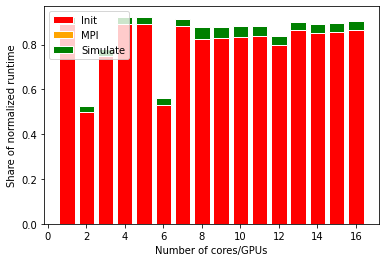

In [18]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])/profiling_data["t_total"]
share_mpi = profiling_data["t_step_mpi_halo_exchange"]/profiling_data["t_total"]
share_simulate = profiling_data["t_step_mpi"]/profiling_data["t_total"]

plt.bar(profiling_data["n_processes"], 
    share_init, color='red', edgecolor='white', width=bar_width, label="Init")

plt.bar(profiling_data["n_processes"], 
    share_mpi, bottom=share_init, color='orange', edgecolor='white', width=bar_width, label="MPI")

plt.bar(profiling_data["n_processes"], 
    share_simulate, bottom=share_init+share_mpi , color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Share of normalized runtime")
plt.legend(loc="upper left")

plt.show()

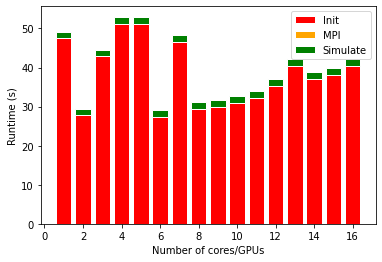

In [19]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])
share_mpi = profiling_data["t_step_mpi_halo_exchange"]
share_simulate = profiling_data["t_step_mpi"]

plt.bar(profiling_data["n_processes"], 
    share_init, color='red', edgecolor='white', width=bar_width, label="Init")

plt.bar(profiling_data["n_processes"], 
    share_mpi, bottom=share_init, color='orange', edgecolor='white', width=bar_width, label="MPI")

plt.bar(profiling_data["n_processes"], 
    share_simulate, bottom=share_init+share_mpi , color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Runtime (s)")
plt.legend(loc="upper right")

plt.show()

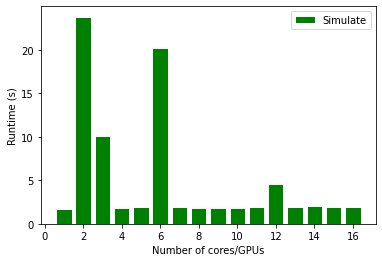

In [22]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])
share_mpi = profiling_data["t_step_mpi_halo_exchange"]
share_simulate = profiling_data["t_step"]


plt.bar(profiling_data["n_processes"], 
    share_simulate, color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Runtime (s)")
plt.legend(loc="upper right")

plt.show()

1. ~~Sjekk opp behandling av randvilkår. Fungerer ikke som det skal. Offset-problematikk. Få periodiske render til å funke med 1 (først hele domenet, så indre og yttre domene) og 2 subdomener.~~
2. Sjekk overføringer east-west. Kan vi droppe? – Ja, men se punkt 1.
3. ~~Sjekk IC-bug? Bare to felter i K-H?!~~
4. ~~Kjør lenger kjøring~~
5. Sjekk på OsloMet-boks!
6. Sjekk reproduserbarhet av løsning
7. Ny profilering og sjekk av parallelkjøring